# Markov Chain Monte Carlo with Couplings, parallelized, multivariate mean Gaussian

## Modules importing

In [1]:
# system modules
import os
import time

# mathematical and statistical modules
import math
import numpy as np
import pandas as pd
import scipy.stats as sstat
#from mpmath import mp

# tensorflow modules
import tensorflow_probability.substrates.numpy as tfp
import tensorflow_probability.substrates.numpy.distributions as tfd
import tensorflow.random as tfr

# visualization and plotting modules
import matplotlib.pyplot as plt
import seaborn as sns

# parallelization modules 
from multiprocessing import Process, Queue, SimpleQueue

2022-01-09 17:55:27.914941: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-09 17:55:27.914994: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Settings and data

### Parameters

In [2]:
#data
number_of_data     = 100
observations_mean  = np.array([10. , 20.])
observations_sd    = np.sqrt(5.) 
dimensionality = 2

#prior
prior_mean = np.array([12., 18.])
prior_sd = 3

#mcmc setting
#x_start = np.array([14., 23.])
#y_start = np.array([ 8., 16.])
iterations = 800
burnout = 100

# coupling tolerance
chains_matching_tolerance = 1e-3

# time averaged estimator parameter
test_function_h = lambda x: x

### Funcion creations

#### Generation of data
Data are generated and placed in the variable "observations_y"; those data will be used in the likelihood function.

In [3]:
observations_y = np.array(
    np.random.multivariate_normal(
        mean=observations_mean, 
        cov=(observations_sd**2)*np.eye(dimensionality), 
        size=number_of_data
    )
)

In [4]:
observations_y.shape

(100, 2)

### Likelihood functions

In [5]:
def likelihood(mu):
    tau = 1/(observations_sd**2)
    return np.exp(  
        -(tau/2)*( 
            number_of_data * (mu - observations_mean)**2 
            + np.sum( (observations_y - observations_mean)**2, axis = 0) 
            )  
        ) * 10.**10 #this coefficient is to avoid annihilation - it's a rescale

In [6]:
likelihood([12., 18.])#, observations_y, observations_mean, observations_sd, number_of_data)

array([8.87715266e-32, 8.06108622e-27])

### Prior density function - setting of prior parameters

In [7]:
def prior(value):
    dimensionality =  prior_mean.shape[0]
    return sstat.multivariate_normal(
        prior_mean, 
        (prior_sd**2)*np.eye(dimensionality)
        ).pdf(value)
    #return tfd.MultivariateNormalTriL(
    #    loc = prior_mean, 
    #    scale_tril = prior_sd*np.eye(dimensionality)
    #    ).prob(value)


In [8]:
def prior_sampling():
    dimensionality =  prior_mean.shape[0]
    return sstat.multivariate_normal(
        prior_mean, 
        (prior_sd**2)*np.eye(dimensionality)
        ).rvs(1)
    #return tfd.MultivariateNormalTriL(
    #    loc = prior_mean, 
    #    scale_tril = prior_sd*np.eye(dimensionality)
    #    ).sample(value)


### Target distribution: posterior function
posterior proportional to likelihood times prior distribution

In [9]:
def target(value):
    return likelihood(value)*prior(value)

## Functions

### Maximal coupling of Q
The algorithm:
1)  
    1) sample $X \sim p$
    2) sample $W|X \sim \mathcal{U}\{[0,p(X)]\}$ \
    if $W\leq q(X)$ then output $(X,X)$
2)  otherwise
    1) sample $Y^\star \sim q$
    2) sample $W^\star | Y^\star \sim \mathcal{U}\{[0, q(Y^\star)]\}$ \
    until $W^\star > p(Y^\star)$ and output $(X,Y^\star)$
   

In [10]:
def maximal_coupling(x,y):     
    #check dimensionality consistency
    if len(x) != len(y):
        raise NameError('Dimensionality mismatch!') 
    
    dimensionality = len(x)

    #sampling of X - point 1.A
    #the new candidate is sampled from a normal centered in the given value
    #x_candidate = np.random.multivariate_normal(mean=x, cov=np.eye(dimensionality), size=1)
    x_candidate = sstat.multivariate_normal(x,np.eye(dimensionality)).rvs(1)
    
    #sampling of W|X - point 1.B
    #evaluate pdf centered in x with scale 1 in x_cadidate
    pX = sstat.multivariate_normal(x,np.eye(dimensionality)).pdf(x_candidate)
    W = tfd.Uniform(0,pX).sample()
    #sampling from uniform is inside the cycle on parameters 
    
    # evaluation of qx - point 1 IF
    qX = sstat.multivariate_normal(y, np.eye(dimensionality)).pdf(x_candidate)
    
    if W < qX:
        x = x_candidate
        y = x_candidate
    else:
        while True:
            #sampling of Y* - point 2.A
            y_candidate = sstat.multivariate_normal(y,np.eye(dimensionality)).rvs(1)

            #sampling of W* - point 2.B
            qY = sstat.multivariate_normal(y, np.eye(dimensionality)).pdf(y_candidate)
            W =  tfd.Uniform(0,qY).sample()

            # evaluation of py - point 2
            pY = sstat.multivariate_normal(x,np.eye(dimensionality)).pdf(y_candidate)
            if W > pY :
                break

        x = x_candidate
        y = y_candidate

    return (x, y)

### Metropolis Hastings
The algorithm:
1) sample $(X^\star, Y^\star) | (X_t, Y_{t-1})$ from a maximal coupling of $q(X_t, \cdot)$ and $q(Y_{t-1}, \cdot)$
2) sample $U \sim \mathcal{U}([0,1])$,
3) if $$ U
 				\leq \min\bigg \{
 				1,
 				\frac{ \pi(X^\star)q(X^\star,X_t)}{
 					\pi(X_t)q(X_t, X^\star)}
 				\bigg \} $$ then $X_{t+1} = X^\star$; otherwise $X_t = X_{t-1}$;
4) if $$ U	\leq \min\bigg \{ 
 				1,
 				\frac{ \pi(Y^\star)q(Y^\star,Y_t)}{
 					\pi(Y_t)q(Y_t, Y^\star)}
 				\bigg \} $$
    then $Y_{t+1} = Y^\star$; otherwise $Y_t = Y_{t-1}$.
   

In [11]:
def metropolis_hastings(iterations):
    
    x = prior_sampling()
    y = prior_sampling()
    # check dimensionality consistency
    if len(x) != len(y):
        raise NameError('Dimensionality mismatch!') 
    
    dimensionality = len(x)
    
    x = np.array(x)
    y = np.array(y)
    
    # initializing empty np arrays
    X = np.empty([dimensionality, iterations])
    Y = np.empty([dimensionality, iterations])


    for i in range(iterations):
        # sample from maximal coupling - point 1
        (x_candidate, y_candidate) = maximal_coupling(x,y) #da qui deve uscire già multivariato
        x_candidate = np.array(x_candidate)
        y_candidate = np.array(y_candidate)
        
        
        # sample from a uniform - point 2
        u = tfd.Uniform(0,1).sample()
        
        # points 3 and 4 are to be executed on all the parameters which determine the dimensionality
        for param in range(dimensionality):
            # check if the sampling of X is accepted or to consider the previous - point 3
            if target(x)[param] == 0:              # to avoid zero division          
                x[param] = x_candidate[param]        
            elif u < min([1., target(x_candidate)[param]/target(x)[param]]) :
                x[param] = x_candidate[param]       
                        
            X[param, i] = x[param]

            # same for Y - point 4
            if target(y)[param] == 0:                     
                y[param] = y_candidate[param]      
            elif u < min([1., target(y_candidate)[param]/target(y)[param]]) :
                y[param] = y_candidate[param]        
        
            Y[param, i] = y[param]
          
    return X, Y

### Time Averaged estimator
The algorithm:
1) draw $X_0$ and $Y_0$ from an initial distribution $\pi_0$ and draw $X_1 \sim P(X_0, \cdot)$;
2) set $t=1$: while $t<\max\{m,\tau\}$ and:
    1) draw $(X_{t+1}, Y_t)\sim \bar P \{(X_t, Y_{t-1}), \cdot \}$; 
    2) set $t \leftarrow t+1$;
3) compute the time-averaged estimator:
	$$ H_{k:m}(X,Y)
	 		= \frac{1}{m-k+1}\sum_{l=k}^{m}h(X_l) 
	 		+ \sum_{l=k+1}^{\tau -1}\min(1, \frac{l-k}{m-k+1})\{h(X_l)-h(Y_{l-1})\} .
	 		$$

In [12]:
def time_averaged_estimator(red_chain, blue_chain, iterations, burnout, meeting_time):
    #this function calculates only the formula at point 3
    
    #first addend
    first_sum = 0
    for i in range(burnout, iterations):
        first_sum += test_function_h(red_chain[i])
    
    #second addend
    second_sum = 0
    if meeting_time-1 > burnout + 1:
        for i in range(burnout + 1, meeting_time):
            # calculing the coefficient, and the min
            coef = (1-burnout)(iterations - burnout + 1)
            if coef > 1:
                coef = 1
            second_sum += coef * (test_function_h(red_chain[i])- test_function_h(blue_chain[i]))
            
    return (1/(iterations - burnout + 1))*first_sum + second_sum
    

### Parallelized operations
This function is given to each available processor

In [13]:
def parallelized_operations(iterations, burnout, chains_matching_tolerance, q_chain, q_meeting_time, q_time_averaged_estimator):
    # setting a random seed - otherwise multiprocessing has the same seed and so they end up in the same chains!
    np.random.seed(int(os.getpid() * time.time()) % 123456789 )
    tfr.set_seed(int(os.getpid() * time.time()) % 123456789 )
    
    #running metropolis hastings and obtaining two chains
    (red_chain, blue_chain) = metropolis_hastings(iterations)
    
    #get the dimensionality from one of the chains
    dimensionality = red_chain.shape[0]

    #finding the meeting time
    meeting_time = iterations + 2
    for i in range(0, iterations):
        if (abs(red_chain[:,i]-blue_chain[:,i]).all() < chains_matching_tolerance) & \
            (abs(red_chain[:,i]-blue_chain[:,i]).all() < chains_matching_tolerance) & \
            (abs(red_chain[:,i]-blue_chain[:,i]).all() < chains_matching_tolerance):
            meeting_time = i
            break
    
    #checking if the chains met
    if meeting_time == iterations+2:
        print('Matching did not occurred!')
        print(meeting_time)
        return
    
    #checking if the chains met before burnout
    if meeting_time >= burnout:
        print('Meeting time occurs after burnout iterations!')
        print(meeting_time)
        return
    
    time_averaged_estimation = np.empty(dimensionality)
    
    for param in range(dimensionality):
        time_averaged_estimation[param] = time_averaged_estimator(
            red_chain[param,], 
            blue_chain[param,], 
            iterations, burnout, meeting_time
        )
    #print(red_chain)
    q_chain.put( red_chain )
    q_meeting_time.put( meeting_time )
    q_time_averaged_estimator.put( time_averaged_estimation )
    
    return

    

## Execution

### Multiprocessing settings

In [14]:
# this returns the number of available processors
num_processes = os.cpu_count()
num_processes

8

In [15]:
# this set the number of iteration, it should be a multiple of the number of available processors
num_batches_set = 4 #16*1 #set this
num_batches = num_batches_set

In [16]:
# this initialize a shared memory between processors
# note of Queue(maxsize = 0)
q_chain = SimpleQueue()
q_meeting_time = SimpleQueue()
q_time_averaged_estimator = SimpleQueue()

### Multiprocessing execution

In [17]:
dimensionality = observations_y.shape[1] #observations has inverted shape!

samplings = np.empty([dimensionality, 0])#np.empty([dimensionality, 0])
time_averaged_estimation_sum = 0
meeting_times = np.empty(0)
correct_chains = 0

while num_batches > 0:
    
    print("There are " + str(num_batches) + " left")
    
    if num_batches >= num_processes:
        current_number_processes = num_processes
    else:
        current_number_processes = num_batches
    
    processes = []
    for batch in range(current_number_processes):
        p = Process(
            target = parallelized_operations, 
            args = (iterations, burnout, 
                    chains_matching_tolerance, 
                    q_chain, q_meeting_time, q_time_averaged_estimator)
        )
        processes.append(p)

    num_batches -= current_number_processes
    
    # Starting the processes in a batch
    for p in processes:
        p.start()
        time.sleep(0.1)

    # This assures that each process in the batch is complete
    for p in processes:
        p.join()

    #unfolding queues
    while not q_chain.empty():
        red_chain = q_chain.get()
        #print('lmao')
        #print(red_chain)
        samplings = np.append(
            samplings,
            red_chain[:,burnout :],
            axis = 1
        )

        meeting_time = q_meeting_time.get()
        time_averaged_estimation = q_time_averaged_estimator.get()
        
        if meeting_time <= burnout: #this to avoid a biased time averaged estimator
            time_averaged_estimation_sum += time_averaged_estimation
            correct_chains += 1
        
        meeting_times = np.append(
            meeting_times,
            meeting_time
        )
    
del q_chain, q_meeting_time, q_time_averaged_estimator
print('All processes are complete!')

There are 4 left
All processes are complete!


## Output and plotting

### Correct executions infos

In [18]:
print(meeting_times)
print(len(meeting_times))
print(num_batches_set-len(meeting_times))

[ 6.  7.  3. 14.]
4
0


In [19]:
samplings.size

5600

### Time averaged estimator

In [20]:
time_averaged_estimation_mean = time_averaged_estimation_sum/correct_chains
time_averaged_estimation_mean

array([ 9.99636906, 19.95417996])

### Plots

In [21]:
sns.set_theme(style="darkgrid")
plt.rcParams["figure.figsize"] = (12,4)

#### Sampling plot and Histogram for all variables

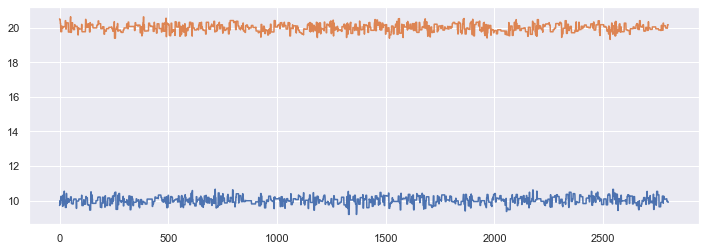

In [22]:
for param in range(samplings.shape[0]):
    plt.plot(samplings[param,:])
plt.savefig('coupling_mult_sampling.png')

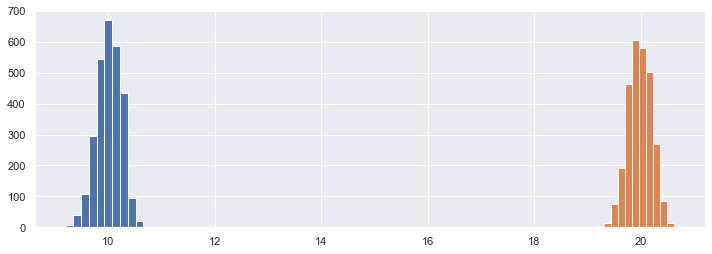

In [23]:
for param in range(samplings.shape[0]):
    plt.hist(samplings[param,:], bins = 10)
plt.savefig('coupling_mult_histogram.png')

#### Sampling for each variable

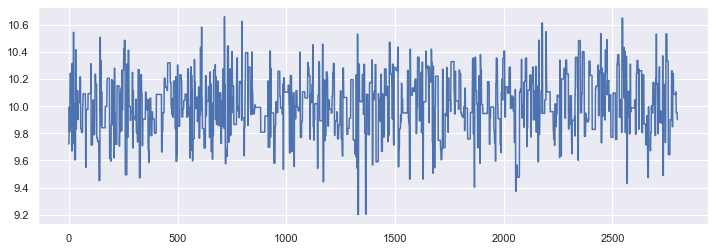

In [24]:
plt.plot(samplings[0,:])
plt.savefig('coupling_mult_sampling_1.png')

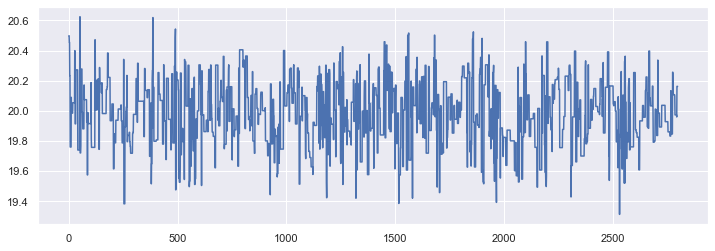

In [25]:
plt.plot(samplings[1,:])
plt.savefig('coupling_mult_sampling_2.png')

#### Meeting time for each variable
Note that a MH is runned to have both chains as an example

In [37]:
(red_chain, blue_chain) = metropolis_hastings(iterations)

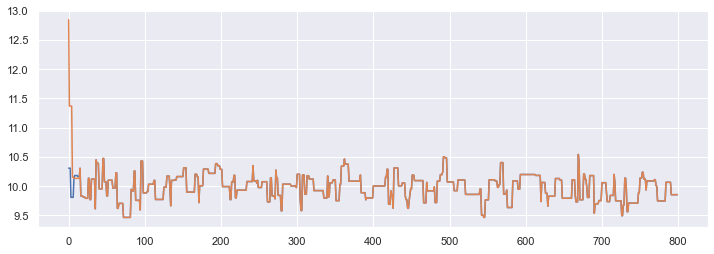

In [27]:
plt.plot(red_chain[0,:])
plt.plot(blue_chain[0,:])
plt.savefig('coupling_mult_chain_meeeting_1.png')

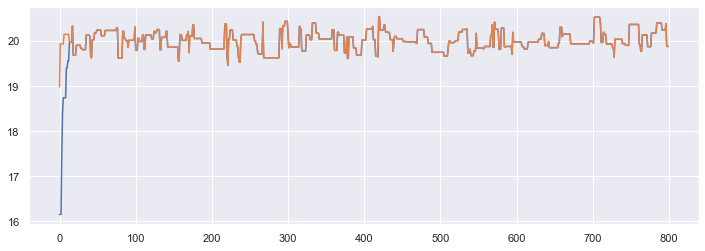

In [28]:
plt.plot(red_chain[1,:])
plt.plot(blue_chain[1,:])
plt.savefig('coupling_mult_chain_meeeting_2.png')

#### Histograms for all variables with real posterior

In [29]:
real_mu_1 = 1/(1/prior_sd**2 + number_of_data/observations_sd**2)*(prior_mean[0]/prior_sd**2 + (np.sum(observations_y[:,0])/observations_sd**2))
real_mu_1

10.183178041004005

In [30]:
np.mean(samplings[0])

10.010649584793049

In [31]:
real_mu_2 = 1/(1/prior_sd**2 + number_of_data/observations_sd**2)*(prior_mean[1]/prior_sd**2 + (np.sum(observations_y[:,1])/observations_sd**2))
real_mu_2

20.1567834269812

In [32]:
np.mean(samplings[1,:])

19.98268593552257

In [33]:
real_sd = np.sqrt(1/(1/prior_sd**2 + number_of_data/observations_sd**2))
real_sd**2

0.04972375690607736

In [34]:
np.cov(samplings)

array([[0.05047333, 0.00039542],
       [0.00039542, 0.04689662]])

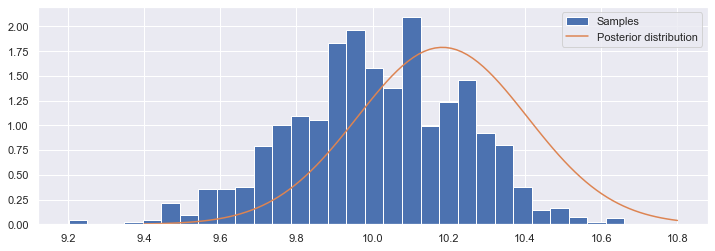

In [35]:
x = np.linspace(9.4, 10.8,100)

plt.hist(samplings[0,:], bins = 30, density=True, label='Samples')
plt.plot(x, sstat.norm.pdf(x, real_mu_1, real_sd ) , label= 'Posterior distribution' )

plt.legend()

plt.savefig('coupling_mult_histogram_1.png')

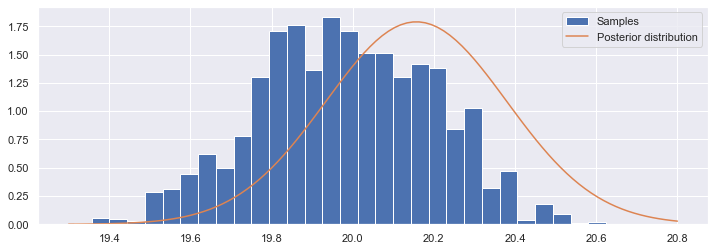

In [36]:
x = np.linspace(19.3, 20.8, 100)

plt.hist(samplings[1,:],bins = 30, density=True, label='Samples')
plt.plot(x, sstat.norm.pdf(x, real_mu_2, real_sd ) , label= 'Posterior distribution' )

plt.legend()

plt.savefig('coupling_mult_histogram_2.png')